# Statistical testing
In this notebook we will use `bia_bob` to apply a statistical test to some example data. The data is tricky (for a reason).

For training purposes, we will use the LLM infrastructure of [ScaDS.AI](https://scads.ai) in the [National Compute Center ZIH TU Dresden](https://tu-dresden.de/zih).

When using bia-bob to prompt LLMs, the prompts you enter including existing variable names etc. are sent to the LLM provider. 
Do not submit any sensitive, secret or private information. Also check bia-bob's code recommendations before executing them. 
LLMs make mistakes.

First, we configure bia-bob:

In [1]:
# load secret API key. You must unpack the contents of api_key.zip 
# into the same folder before going ahead.
from dotenv import load_dotenv
load_dotenv()

import os
from bia_bob import bob
bob.initialize(endpoint='https://llm.scads.ai/v1', model='openai/gpt-oss-120b', api_key=os.environ.get('SCADSAI_API_KEY'))

## The over-simplified approach
In the first attempt, we ask to determine if columns `A` and `B` are significantly different without any further instructions.

In [2]:
%%bob load data/data.csv and 
determine if the columns A and B 
are significantly different.

I will load `data/data.csv` with pandas, extract columns **A** and **B**, and perform an independent two‑sample t‑test (Welch’s test) to check whether their means differ significantly. The test statistic and p‑value will be printed, together with a simple interpretation.



In [3]:
import pandas as pd
from scipy import stats

# 1. Load the CSV file
csv_path = os.path.join("data", "data.csv")
df = pd.read_csv(csv_path)

# 2. Extract columns A and B, removing NaNs
a = df["A"].dropna()
b = df["B"].dropna()

# 3. Perform Welch's t‑test (independent samples, unequal variances)
t_stat, p_val = stats.ttest_ind(a, b, equal_var=False)

# 4. Output the results
print(f"T‑statistic: {t_stat:.4f}")
print(f"P‑value: {p_val:.4e}")

if p_val < 0.05:
    print("Result: Columns A and B are significantly different (p < 0.05).")
else:
    print("Result: No significant difference between columns A and B (p ≥ 0.05).")

T‑statistic: -1.3287
P‑value: 1.8428e-01
Result: No significant difference between columns A and B (p ≥ 0.05).


This result might be misleading, simply because we didn't study the data yet.
Let's plot the data.

In [4]:
%%bob
Plot histograms for A and B

I will create side‑by‑side histograms for the values in columns **A** and **B** that were already loaded into the variables `a` and `b`. The histograms will be displayed with Matplotlib, sharing the same binning for easy visual comparison.



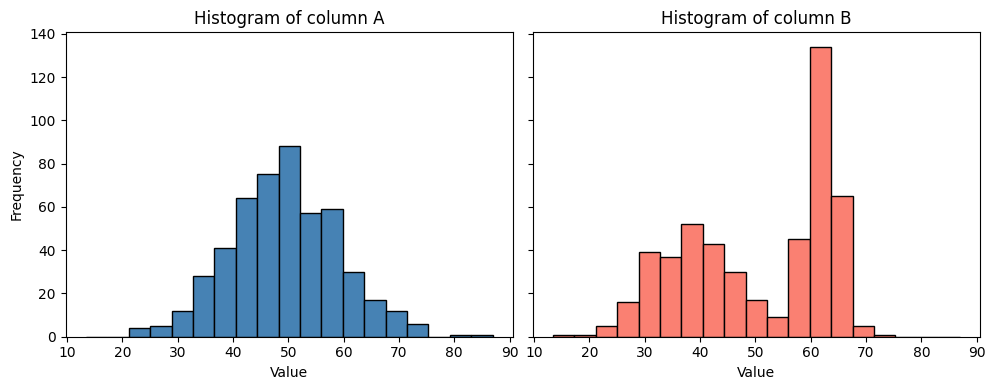

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Determine common bin edges for both datasets
combined = np.concatenate([a.values, b.values])
bin_edges = np.histogram_bin_edges(combined, bins='auto')  # automatic binning

# 2. Plot histograms side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axs[0].hist(a, bins=bin_edges, color='steelblue', edgecolor='black')
axs[0].set_title('Histogram of column A')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

axs[1].hist(b, bins=bin_edges, color='salmon', edgecolor='black')
axs[1].set_title('Histogram of column B')
axs[1].set_xlabel('Value')

plt.tight_layout()
plt.show()

From this visualization we can guess that the data in B is not normal distributed; a pre-condition for the T-test used above.

## Professional statistical testing
An improved prompt contains an additional task: Checking preconditions. Hence, the resulting code will be longer and more detailed.

In [6]:
%%bob
Please test again if columns A and B are significantly different.
Before applying a statistical test, ensure that the necessary 
pre-conditions are met.

I will first check the required assumptions for a parametric test on columns **A** and **B**:

1. **Normality** – Shapiro‑Wilk test for each column.  
2. **Equality of variances** – Levene’s test.

Based on the outcomes:

* If both columns are normal and variances are equal → classic independent‑samples t‑test.  
* If both are normal but variances differ → Welch’s t‑test.  
* If normality is violated for either column → Mann‑Whitney U test (non‑parametric).

The code prints the assumption test results, selects the appropriate statistical test, runs it, and reports the test statistic and p‑value with a brief interpretation.



In [7]:
# Assumption tests and appropriate statistical test
# (All required modules are already imported: stats from scipy, numpy as np, pandas as pd, matplotlib.pyplot as plt, os)

# 1. Normality (Shapiro‑Wilk)
shapiro_a_stat, shapiro_a_p = stats.shapiro(a)
shapiro_b_stat, shapiro_b_p = stats.shapiro(b)

normal_a = shapiro_a_p > 0.05   # fail to reject H0 → data are normal
normal_b = shapiro_b_p > 0.05

# 2. Equality of variances (Levene)
levene_stat, levene_p = stats.levene(a, b)

equal_variance = levene_p > 0.05   # fail to reject H0 → variances equal

print("=== Assumption tests ===")
print(f"Shapiro‑Wilk A:   p = {shapiro_a_p:.4e} → {'normal' if normal_a else 'non‑normal'}")
print(f"Shapiro‑Wilk B:   p = {shapiro_b_p:.4e} → {'normal' if normal_b else 'non‑normal'}")
print(f"Levene variance:  p = {levene_p:.4e} → {'equal variance' if equal_variance else 'unequal variance'}")
print()

# 3. Choose and run the appropriate statistical test
if normal_a and normal_b:
    if equal_variance:
        test_name = "Student's t‑test (equal variances)"
        test_statistic, pvalue = stats.ttest_ind(a, b, equal_var=True)
    else:
        test_name = "Welch's t‑test (unequal variances)"
        test_statistic, pvalue = stats.ttest_ind(a, b, equal_var=False)
else:
    test_name = "Mann‑Whitney U test (non‑parametric)"
    test_statistic, pvalue = stats.mannwhitneyu(a, b, alternative='two-sided')

# 4. Report the result
print(f"=== Selected test: {test_name} ===")
print(f"Statistic = {test_statistic:.4f}")
print(f"P‑value   = {pvalue:.4e}")

alpha = 0.05
if pvalue < alpha:
    print(f"Conclusion: Significant difference (p < {alpha}).")
else:
    print(f"Conclusion: No significant difference (p ≥ {alpha}).")

=== Assumption tests ===
Shapiro‑Wilk A:   p = 5.6236e-01 → normal
Shapiro‑Wilk B:   p = 4.0635e-18 → non‑normal
Levene variance:  p = 1.3016e-18 → unequal variance

=== Selected test: Mann‑Whitney U test (non‑parametric) ===
Statistic = 113657.0000
P‑value   = 1.3000e-02
Conclusion: Significant difference (p < 0.05).


The result is now different: This test _sees_ the differences between the datasets.

## Exercise
Start a new notebook and prompt `bia-bob` in a way that it immediately answers with correct code for analysing `data/data.csv`. 